# Analiza wypadków pieszych i rowerzystów (2014-2024)
## Prognozowanie za pomocą Facebook Prophet

Ten notatnik analizuje dane dotyczące świadczeń zdrowotnych udzielonych osobom poszkodowanym w wypadkach (piesi i rowerzyści) w latach 2014-2024.

## 1. Import bibliotek

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Ustawienia wizualizacji
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("Biblioteki zaimportowane!")

Biblioteki zaimportowane!


## 2. Wczytanie danych z CSV

In [19]:
# Wczytanie danych
df = pd.read_csv('piesi_i_rowerzysci_dane.csv', encoding='utf-8')

print(f"Wczytano dane: {df.shape}")
print(f"\nKolumny: {list(df.columns)}")
print(f"\nPierwsze 5 wierszy:")
df.head()

Wczytano dane: (8556, 6)

Kolumny: ['Rok', 'Miesiąc', 'Rodzaj świadczenia', 'Rozopznanie (Kod ICD-10)', 'Liczba świadczeń', 'Kategoria']

Pierwsze 5 wierszy:


,Rok,Miesiąc,Rodzaj świadczenia,Rozopznanie (Kod ICD-10),Liczba świadczeń,Kategoria
0,2014,styczeń,Podstawowa opieka zdrowotna,Pieszy ranny w kolizji z rowerem (V01),<5,Piesi
1,2014,styczeń,Podstawowa opieka zdrowotna,Pieszy ranny w kolizji z dwu lub trzykolowym p...,<5,Piesi
2,2014,styczeń,Leczenie szpitalne,Pieszy ranny w kolizji z rowerem (V01),<5,Piesi
3,2014,styczeń,Leczenie szpitalne,Pieszy ranny w kolizji z dwu lub trzykolowym p...,<5,Piesi
4,2014,styczeń,Ratownictwo medyczne,Pieszy ranny w kolizji z rowerem (V01),<5,Piesi


## 3. Czyszczenie i przygotowanie danych

In [20]:
# Mapowanie miesięcy polskich na numery
miesiace_map = {
    'styczeń': 1, 'luty': 2, 'marzec': 3, 'kwiecień': 4,
    'maj': 5, 'czerwiec': 6, 'lipiec': 7, 'sierpień': 8,
    'wrzesień': 9, 'październik': 10, 'listopad': 11, 'grudzień': 12
}
df['Miesiąc_num'] = df['Miesiąc'].map(miesiace_map)

# Konwersja na Int64 (aby uniknąć 1.0 zamiast 1)
df['Miesiąc_num'] = df['Miesiąc_num'].astype('Int64')

# Przetworzenie liczby świadczeń (zamień '<5' na 2.5)
def parse_count(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        if '<5' in x:
            return 2.5
        x = x.replace(' ', '').replace(',', '')
    try:
        return float(x)
    except:
        return np.nan

df['Liczba_świadczeń_num'] = df['Liczba świadczeń'].apply(parse_count)

# Tworzenie daty
df['Data'] = pd.to_datetime(
    df['Rok'].astype(str) + '-' + df['Miesiąc_num'].astype(str) + '-01',
    format='%Y-%m-%d',
    errors='coerce'
)

# Usuń wiersze z brakującymi datami lub wartościami
df_clean = df.dropna(subset=['Data', 'Liczba_świadczeń_num']).copy()

print(f"Dane po czyszczeniu: {df_clean.shape}")
print(f"\nZakres dat: {df_clean['Data'].min()} - {df_clean['Data'].max()}")
print(f"\nStatystyki liczby świadczeń:")
print(df_clean['Liczba_świadczeń_num'].describe())
df_clean.head()

Dane po czyszczeniu: (8288, 9)

Zakres dat: 2014-01-01 00:00:00 - 2024-06-01 00:00:00

Statystyki liczby świadczeń:
count    8288.000000
mean       95.546211
std       229.110337
min         2.500000
25%         2.500000
50%        15.000000
75%        74.000000
max      3610.000000
Name: Liczba_świadczeń_num, dtype: float64


,Rok,Miesiąc,Rodzaj świadczenia,Rozopznanie (Kod ICD-10),Liczba świadczeń,Kategoria,Miesiąc_num,Liczba_świadczeń_num,Data
0,2014,styczeń,Podstawowa opieka zdrowotna,Pieszy ranny w kolizji z rowerem (V01),<5,Piesi,1,2.5,2014-01-01
1,2014,styczeń,Podstawowa opieka zdrowotna,Pieszy ranny w kolizji z dwu lub trzykolowym p...,<5,Piesi,1,2.5,2014-01-01
2,2014,styczeń,Leczenie szpitalne,Pieszy ranny w kolizji z rowerem (V01),<5,Piesi,1,2.5,2014-01-01
3,2014,styczeń,Leczenie szpitalne,Pieszy ranny w kolizji z dwu lub trzykolowym p...,<5,Piesi,1,2.5,2014-01-01
4,2014,styczeń,Ratownictwo medyczne,Pieszy ranny w kolizji z rowerem (V01),<5,Piesi,1,2.5,2014-01-01


In [21]:
# Podstawowe statystyki
print("=== PODSTAWOWE STATYSTYKI ===")
print(f"\nRozkład według kategorii:")
print(df_clean['Kategoria'].value_counts())
print(f"\nRozkład według rodzaju świadczenia:")
print(df_clean['Rodzaj świadczenia'].value_counts())
print(f"\nStatystyki liczby świadczeń:")
print(df_clean['Liczba_świadczeń_num'].describe())

=== PODSTAWOWE STATYSTYKI ===

Rozkład według kategorii:
Kategoria
Rowerzyści    6371
Piesi         1917
Name: count, dtype: int64

Rozkład według rodzaju świadczenia:
Rodzaj świadczenia
łącznie                                        1732
Ratownictwo medyczne                           1708
Leczenie szpitalne                             1447
Podstawowa opieka zdrowotna                    1410
Ambulatoryjna opieka specjalistyczna           1188
pozostałe                                       782
Pomoc doraźna i transport sanitarny od 2009      21
Name: count, dtype: int64

Statystyki liczby świadczeń:
count    8288.000000
mean       95.546211
std       229.110337
min         2.500000
25%         2.500000
50%        15.000000
75%        74.000000
max      3610.000000
Name: Liczba_świadczeń_num, dtype: float64


## 4. Analiza eksploracyjna danych (EDA)

In [22]:
# Agregacja danych miesięcznych
df_monthly = df_clean.groupby(['Data', 'Kategoria'])['Liczba_świadczeń_num'].sum().reset_index()

print(f"Dane miesięczne: {df_monthly.shape}")
print(f"\nPierwsze 10 wierszy:")
df_monthly.head(10)

Dane miesięczne: (252, 3)

Pierwsze 10 wierszy:


,Data,Kategoria,Liczba_świadczeń_num
0,2014-01-01,Piesi,92.0
1,2014-01-01,Rowerzyści,1096.0
2,2014-02-01,Piesi,114.5
3,2014-02-01,Rowerzyści,1189.0
4,2014-03-01,Piesi,212.5
5,2014-03-01,Rowerzyści,2686.5
6,2014-04-01,Piesi,232.5
7,2014-04-01,Rowerzyści,4167.0
8,2014-05-01,Piesi,288.0
9,2014-05-01,Rowerzyści,5793.5


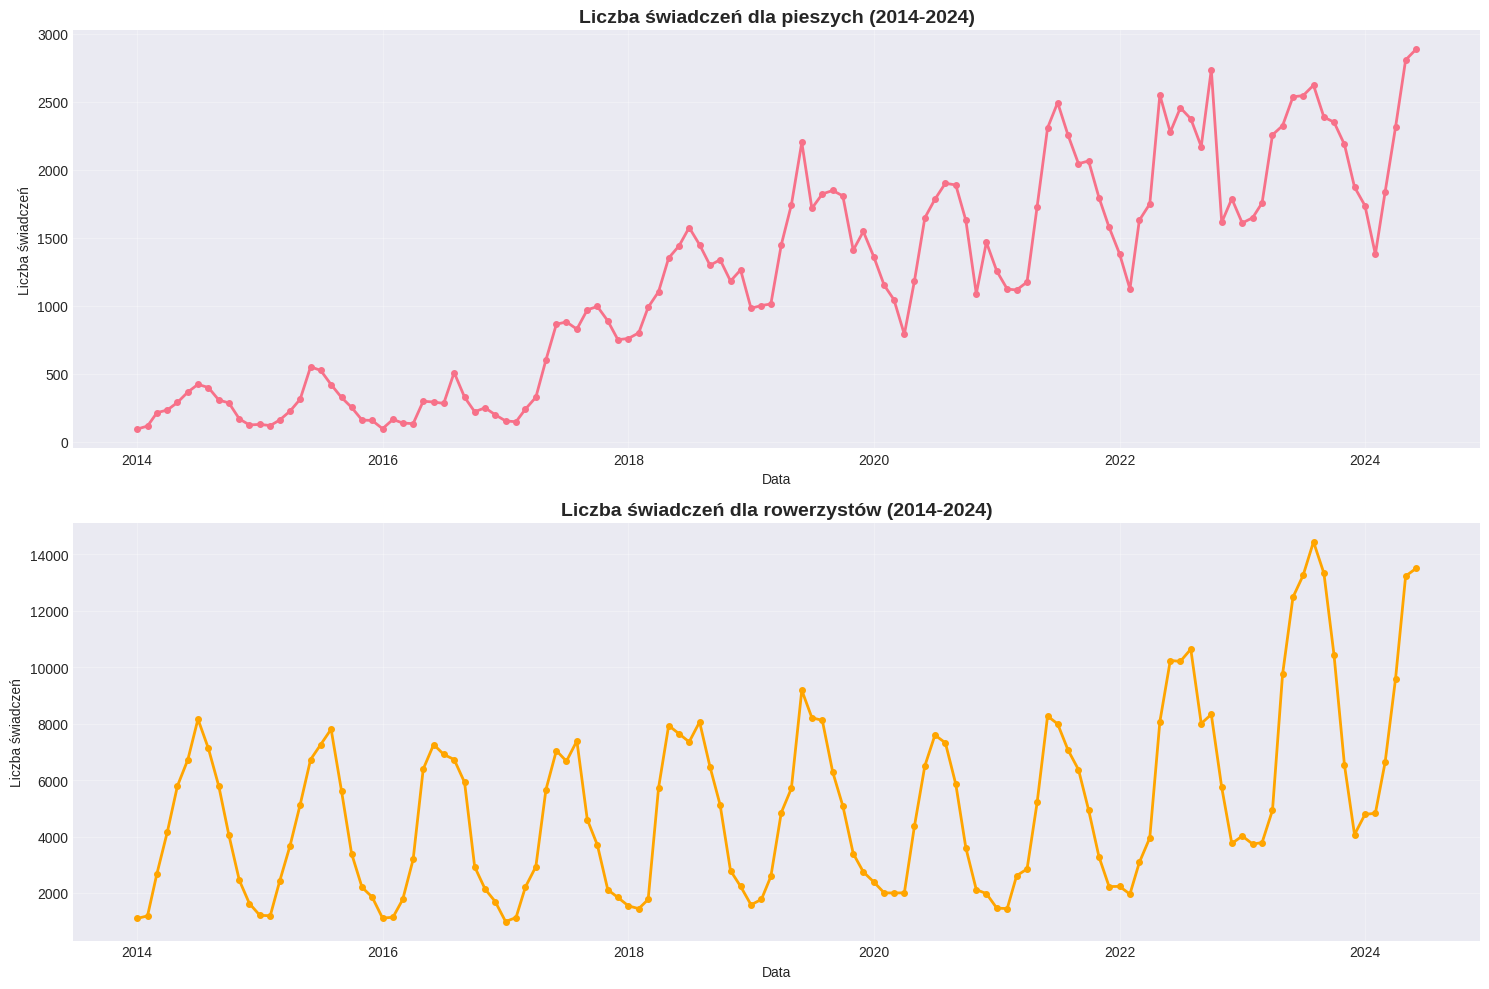

In [23]:
# Wizualizacja trendu czasowego
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Wykres dla pieszych
df_piesi_monthly = df_monthly[df_monthly['Kategoria'] == 'Piesi']
axes[0].plot(df_piesi_monthly['Data'], df_piesi_monthly['Liczba_świadczeń_num'], marker='o', linewidth=2, markersize=4)
axes[0].set_title('Liczba świadczeń dla pieszych (2014-2024)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Liczba świadczeń')
axes[0].grid(True, alpha=0.3)

# Wykres dla rowerzystów
df_rowerzyści_monthly = df_monthly[df_monthly['Kategoria'] == 'Rowerzyści']
axes[1].plot(df_rowerzyści_monthly['Data'], df_rowerzyści_monthly['Liczba_świadczeń_num'], marker='o', linewidth=2, markersize=4, color='orange')
axes[1].set_title('Liczba świadczeń dla rowerzystów (2014-2024)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Liczba świadczeń')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

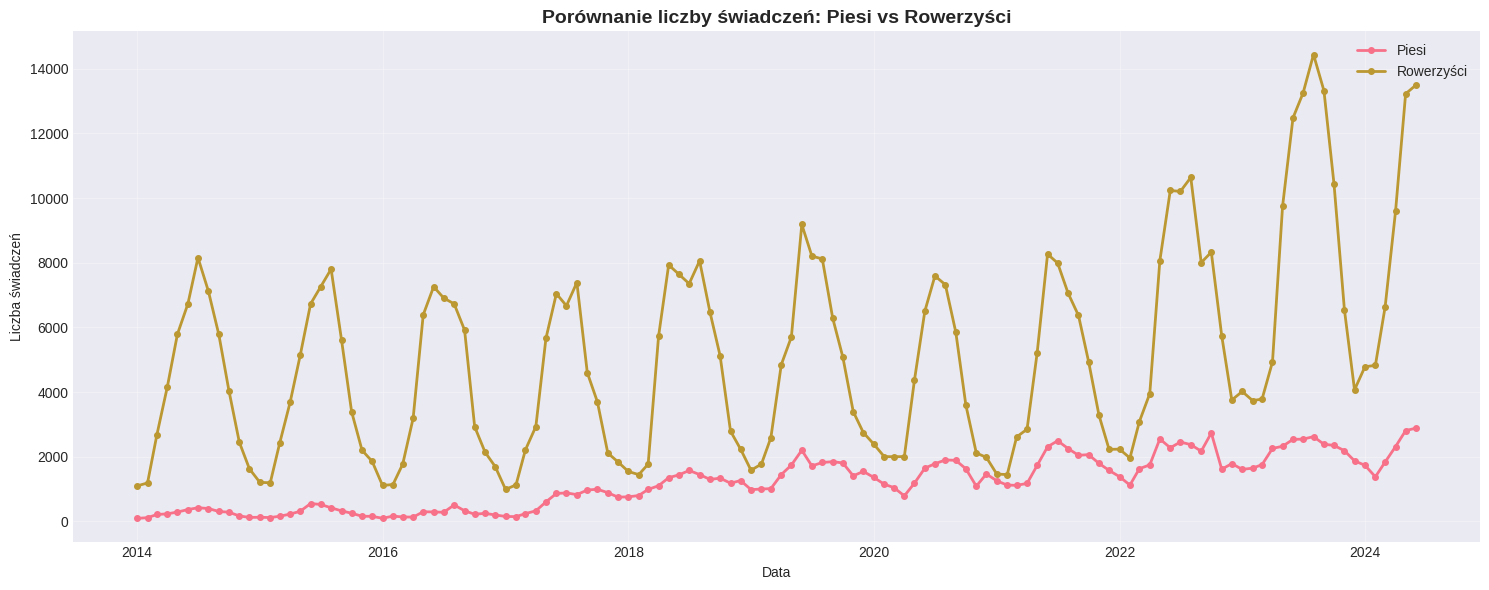

In [24]:
# Porównanie obu kategorii
plt.figure(figsize=(15, 6))
for kategoria in df_monthly['Kategoria'].unique():
    data = df_monthly[df_monthly['Kategoria'] == kategoria]
    plt.plot(data['Data'], data['Liczba_świadczeń_num'], marker='o', label=kategoria, linewidth=2, markersize=4)

plt.title('Porównanie liczby świadczeń: Piesi vs Rowerzyści', fontsize=14, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Liczba świadczeń')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

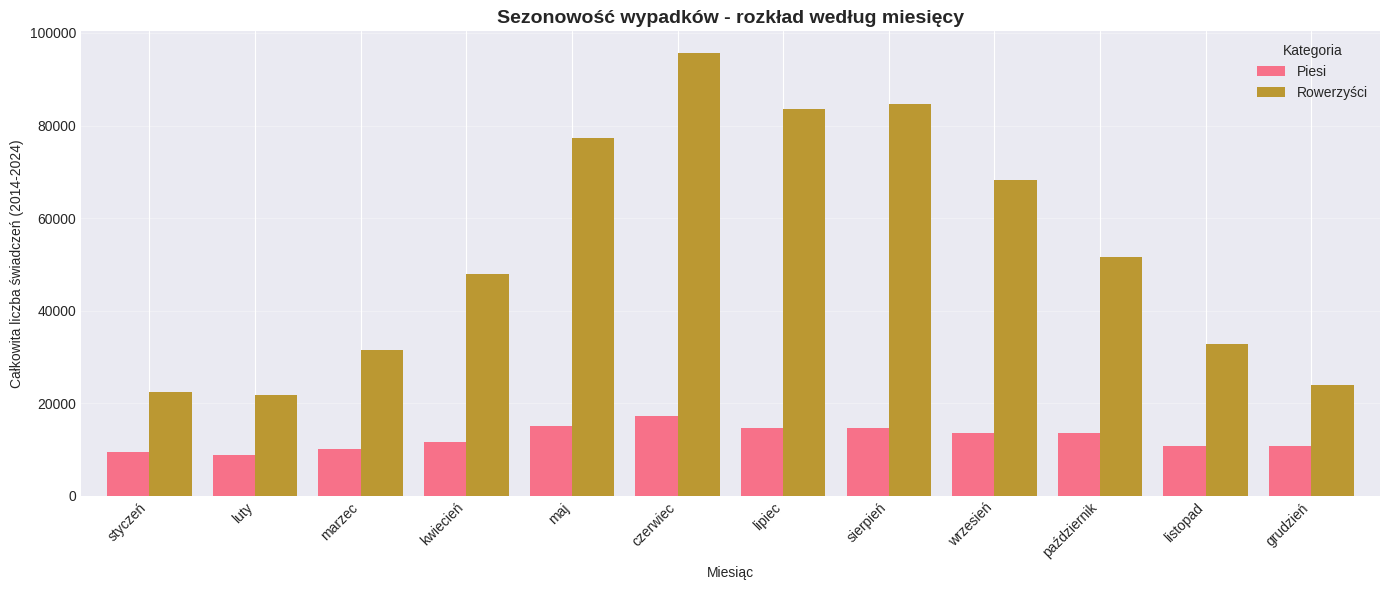

In [25]:
# Analiza sezonowości - rozkład według miesięcy
df_seasonal = df_clean.groupby(['Miesiąc', 'Kategoria'])['Liczba_świadczeń_num'].sum().reset_index()

# Sortowanie miesięcy w kolejności kalendarzowej
miesiace_order = ['styczeń', 'luty', 'marzec', 'kwiecień', 'maj', 'czerwiec', 
                  'lipiec', 'sierpień', 'wrzesień', 'październik', 'listopad', 'grudzień']
df_seasonal['Miesiąc'] = pd.Categorical(df_seasonal['Miesiąc'], categories=miesiace_order, ordered=True)
df_seasonal = df_seasonal.sort_values('Miesiąc')

plt.figure(figsize=(14, 6))
pivot_seasonal = df_seasonal.pivot(index='Miesiąc', columns='Kategoria', values='Liczba_świadczeń_num')
pivot_seasonal.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Sezonowość wypadków - rozkład według miesięcy', fontsize=14, fontweight='bold')
plt.xlabel('Miesiąc')
plt.ylabel('Całkowita liczba świadczeń (2014-2024)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Kategoria')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

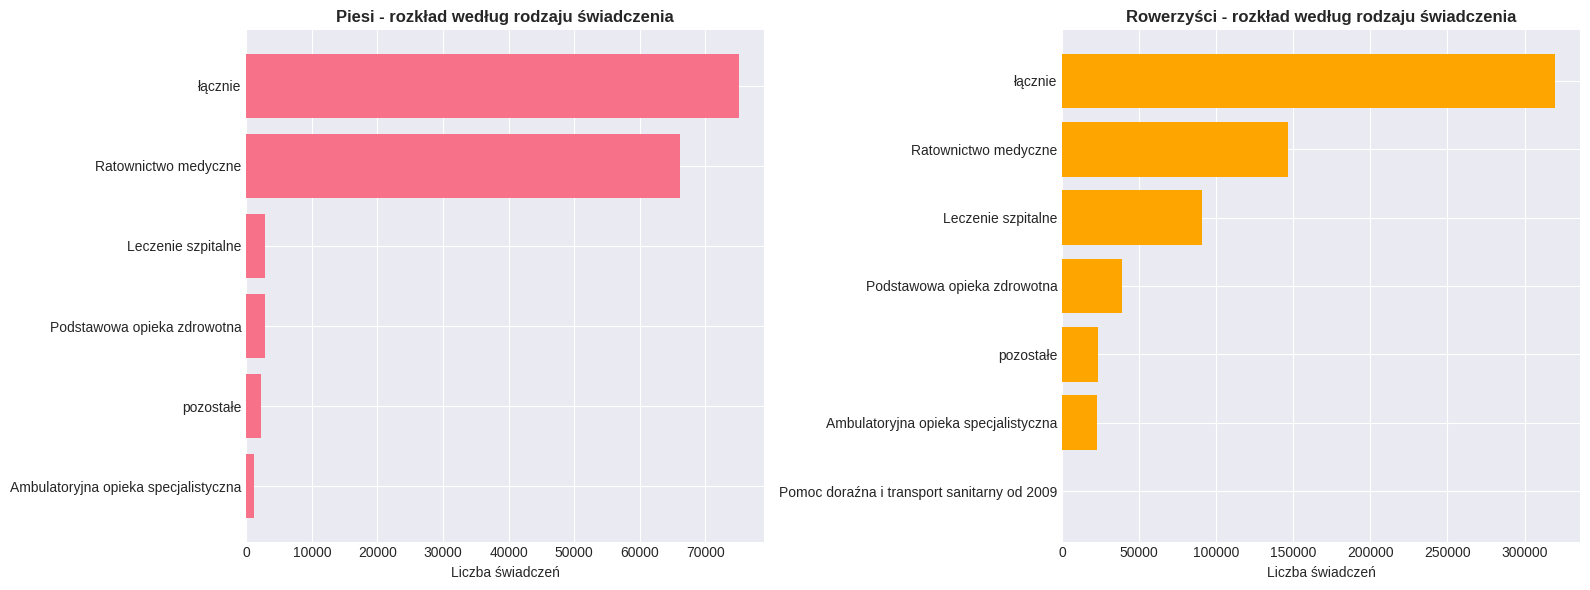

In [26]:
# Analiza według rodzaju świadczenia
df_service = df_clean.groupby(['Rodzaj świadczenia', 'Kategoria'])['Liczba_świadczeń_num'].sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Piesi
piesi_service = df_service[df_service['Kategoria'] == 'Piesi'].sort_values('Liczba_świadczeń_num', ascending=True)
axes[0].barh(piesi_service['Rodzaj świadczenia'], piesi_service['Liczba_świadczeń_num'])
axes[0].set_title('Piesi - rozkład według rodzaju świadczenia', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Liczba świadczeń')

# Rowerzyści
row_service = df_service[df_service['Kategoria'] == 'Rowerzyści'].sort_values('Liczba_świadczeń_num', ascending=True)
axes[1].barh(row_service['Rodzaj świadczenia'], row_service['Liczba_świadczeń_num'], color='orange')
axes[1].set_title('Rowerzyści - rozkład według rodzaju świadczenia', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Liczba świadczeń')

plt.tight_layout()
plt.show()

## 5. Przygotowanie danych dla Facebook Prophet

In [27]:
# Przygotowanie danych dla Prophet - format: ds (data), y (wartość)
# Model dla pieszych
df_prophet_piesi = df_monthly[df_monthly['Kategoria'] == 'Piesi'][['Data', 'Liczba_świadczeń_num']].copy()
df_prophet_piesi.columns = ['ds', 'y']
df_prophet_piesi = df_prophet_piesi.sort_values('ds').reset_index(drop=True)

# Model dla rowerzystów
df_prophet_rowerzyści = df_monthly[df_monthly['Kategoria'] == 'Rowerzyści'][['Data', 'Liczba_świadczeń_num']].copy()
df_prophet_rowerzyści.columns = ['ds', 'y']
df_prophet_rowerzyści = df_prophet_rowerzyści.sort_values('ds').reset_index(drop=True)

print("Dane przygotowane dla Prophet:")
print(f"Piesi: {df_prophet_piesi.shape}")
print(f"Rowerzyści: {df_prophet_rowerzyści.shape}")
print("\nPierwsze 5 wierszy (Piesi):")
print(df_prophet_piesi.head())
print("\nPierwsze 5 wierszy (Rowerzyści):")
print(df_prophet_rowerzyści.head())

Dane przygotowane dla Prophet:
Piesi: (126, 2)
Rowerzyści: (126, 2)

Pierwsze 5 wierszy (Piesi):
          ds      y
0 2014-01-01   92.0
1 2014-02-01  114.5
2 2014-03-01  212.5
3 2014-04-01  232.5
4 2014-05-01  288.0

Pierwsze 5 wierszy (Rowerzyści):
          ds       y
0 2014-01-01  1096.0
1 2014-02-01  1189.0
2 2014-03-01  2686.5
3 2014-04-01  4167.0
4 2014-05-01  5793.5


## 6. Budowa modelu Facebook Prophet dla Pieszych

In [29]:
# Model dla pieszych
print("=== BUDOWA MODELU DLA PIESZYCH ===")

# Inicjalizacja modelu z sezonowością
model_piesi = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
)

# Dodanie sezonowości miesięcznej
model_piesi.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Trenowanie modelu
model_piesi.fit(df_prophet_piesi)

print("\nModel dla pieszych wytrenowany!")

23:55:37 - cmdstanpy - INFO - Chain [1] start processing
23:55:37 - cmdstanpy - INFO - Chain [1] done processing


=== BUDOWA MODELU DLA PIESZYCH ===

Model dla pieszych wytrenowany!


In [30]:
# Tworzenie prognoz na 24 miesiące do przodu
future_piesi = model_piesi.make_future_dataframe(periods=24, freq='MS')
forecast_piesi = model_piesi.predict(future_piesi)

# Wyświetlenie prognozy
print("Prognoza na najbliższe 12 miesięcy (Piesi):")
print(forecast_piesi[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))

Prognoza na najbliższe 12 miesięcy (Piesi):
            ds         yhat   yhat_lower   yhat_upper
138 2025-07-01  3145.002227  2898.190091  3372.618976
139 2025-08-01  3219.034685  2966.606324  3468.533999
140 2025-09-01  3086.223175  2852.919774  3323.541338
141 2025-10-01  3062.568492  2812.446065  3308.004190
142 2025-11-01  2532.730496  2293.880729  2781.080973
143 2025-12-01  2472.448549  2228.492027  2711.210469
144 2026-01-01  2297.661398  2048.251259  2553.671948
145 2026-02-01  2150.560683  1910.920166  2386.196598
146 2026-03-01  1852.793060  1615.604187  2083.148204
147 2026-04-01  2370.415177  2131.741337  2622.137269
148 2026-05-01  2767.447706  2528.750590  3019.725594
149 2026-06-01  3274.924718  3032.720905  3547.477817


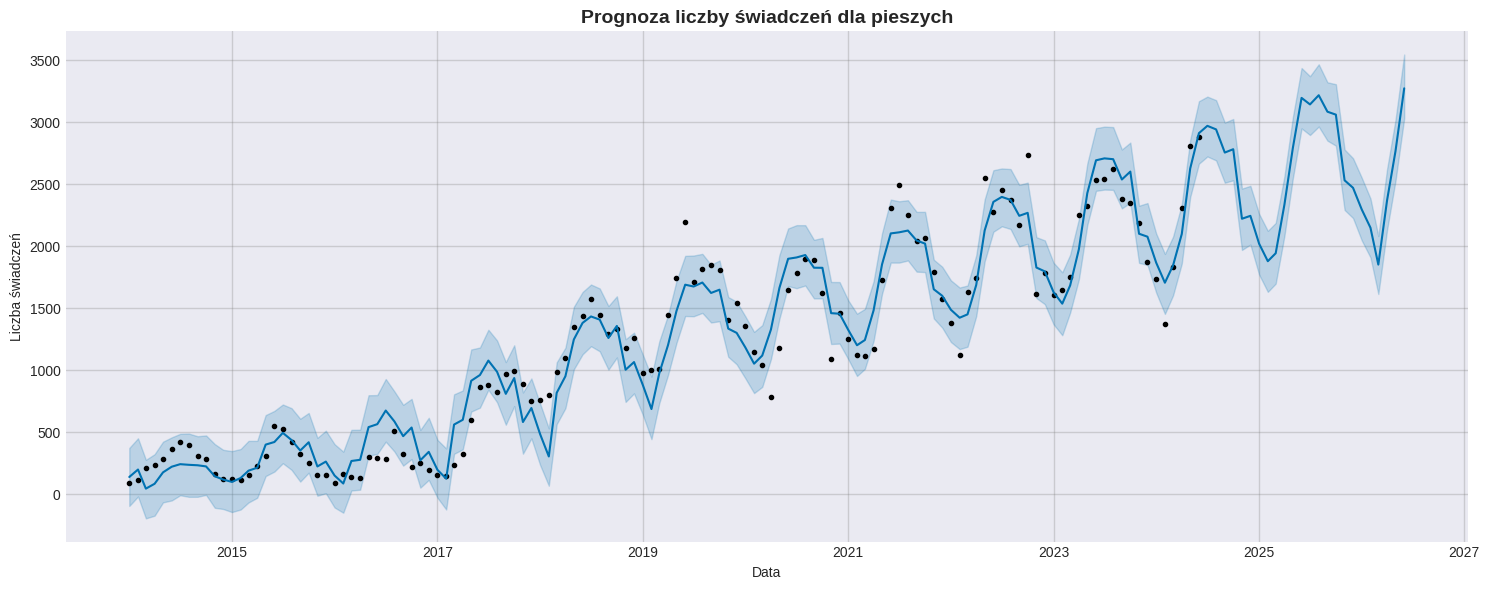

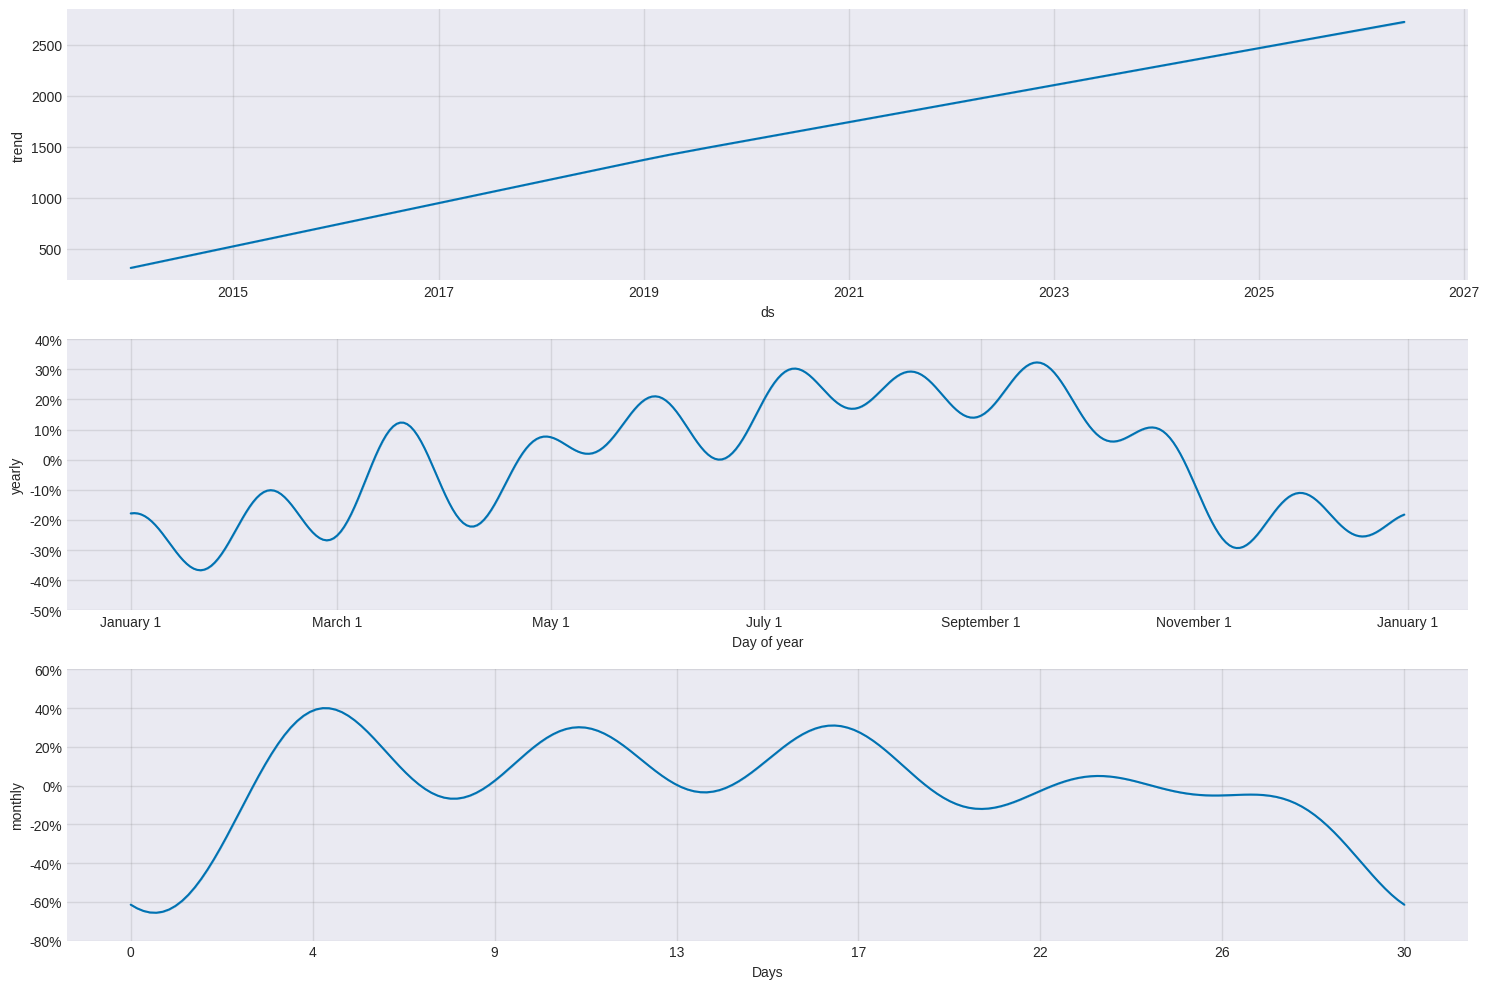

In [31]:
# Wizualizacja prognozy - Piesi
fig1 = model_piesi.plot(forecast_piesi, figsize=(15, 6))
plt.title('Prognoza liczby świadczeń dla pieszych', fontsize=14, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Liczba świadczeń')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Komponenty modelu
fig2 = model_piesi.plot_components(forecast_piesi, figsize=(15, 10))
plt.tight_layout()
plt.show()

## 7. Budowa modelu Facebook Prophet dla Rowerzystów

In [ ]:
# Model dla rowerzystów
print("=== BUDOWA MODELU DLA ROWERZYSTÓW ===")

model_rowerzyści = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
)

# Dodanie sezonowości miesięcznej
model_rowerzyści.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Trenowanie modelu
model_rowerzyści.fit(df_prophet_rowerzyści)

print("\nModel dla rowerzystów wytrenowany!")

23:56:03 - cmdstanpy - INFO - Chain [1] start processing
23:56:03 - cmdstanpy - INFO - Chain [1] done processing


=== BUDOWA MODELU DLA ROWERZYSTÓW ===

Model dla rowerzystów wytrenowany!


In [33]:
# Tworzenie prognoz na 24 miesiące do przodu
future_rowerzyści = model_rowerzyści.make_future_dataframe(periods=24, freq='MS')
forecast_rowerzyści = model_rowerzyści.predict(future_rowerzyści)

# Wyświetlenie prognozy
print("Prognoza na najbliższe 12 miesięcy (Rowerzyści):")
print(forecast_rowerzyści[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))

Prognoza na najbliższe 12 miesięcy (Rowerzyści):
            ds          yhat    yhat_lower    yhat_upper
138 2025-07-01  17113.327478  16272.955209  18055.103468
139 2025-08-01  18823.402176  17974.436723  19707.348516
140 2025-09-01  16449.264318  15491.773091  17343.407646
141 2025-10-01  12083.535157  11177.334730  12990.140820
142 2025-11-01   8976.291760   8058.222334   9867.520806
143 2025-12-01   6138.021650   5360.191063   6976.969212
144 2026-01-01   6466.413804   5610.067918   7297.989833
145 2026-02-01   6826.129987   5929.574046   7647.542997
146 2026-03-01   1418.916692    649.463322   2296.985231
147 2026-04-01   7232.562018   6338.344886   8076.194883
148 2026-05-01  10578.820885   9601.951851  11530.736148
149 2026-06-01  16659.523296  15640.898174  17628.611440


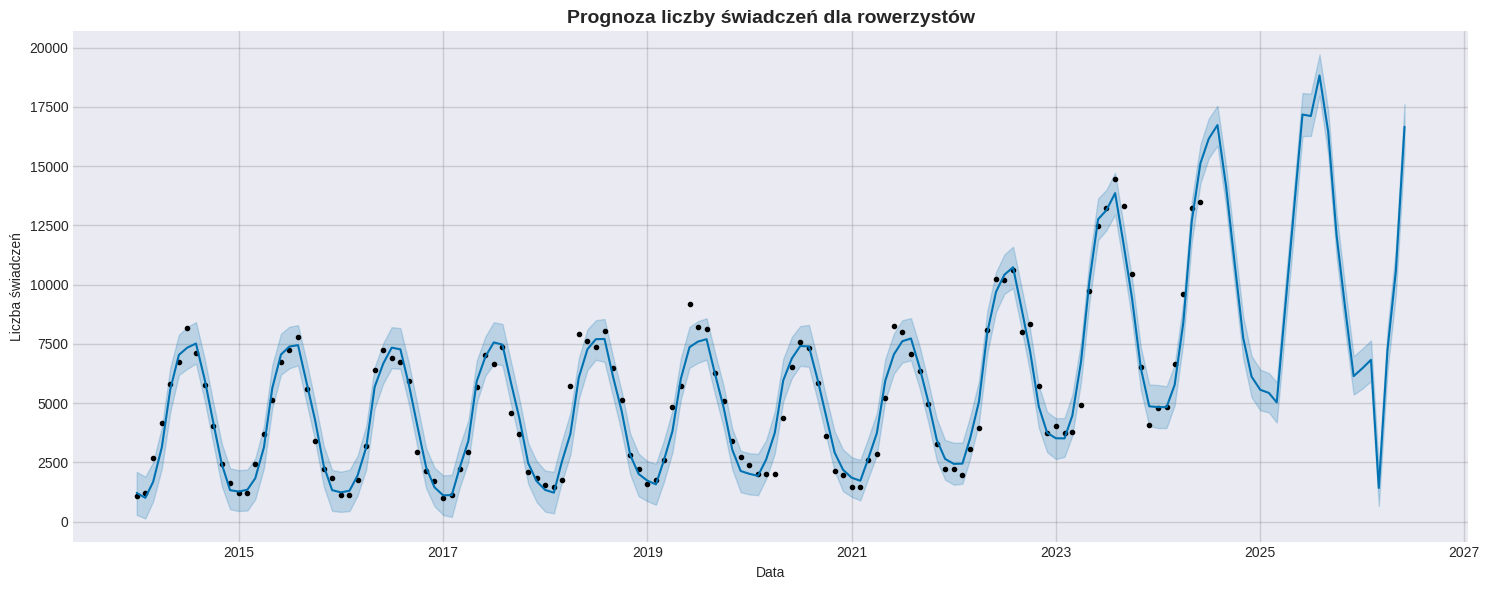

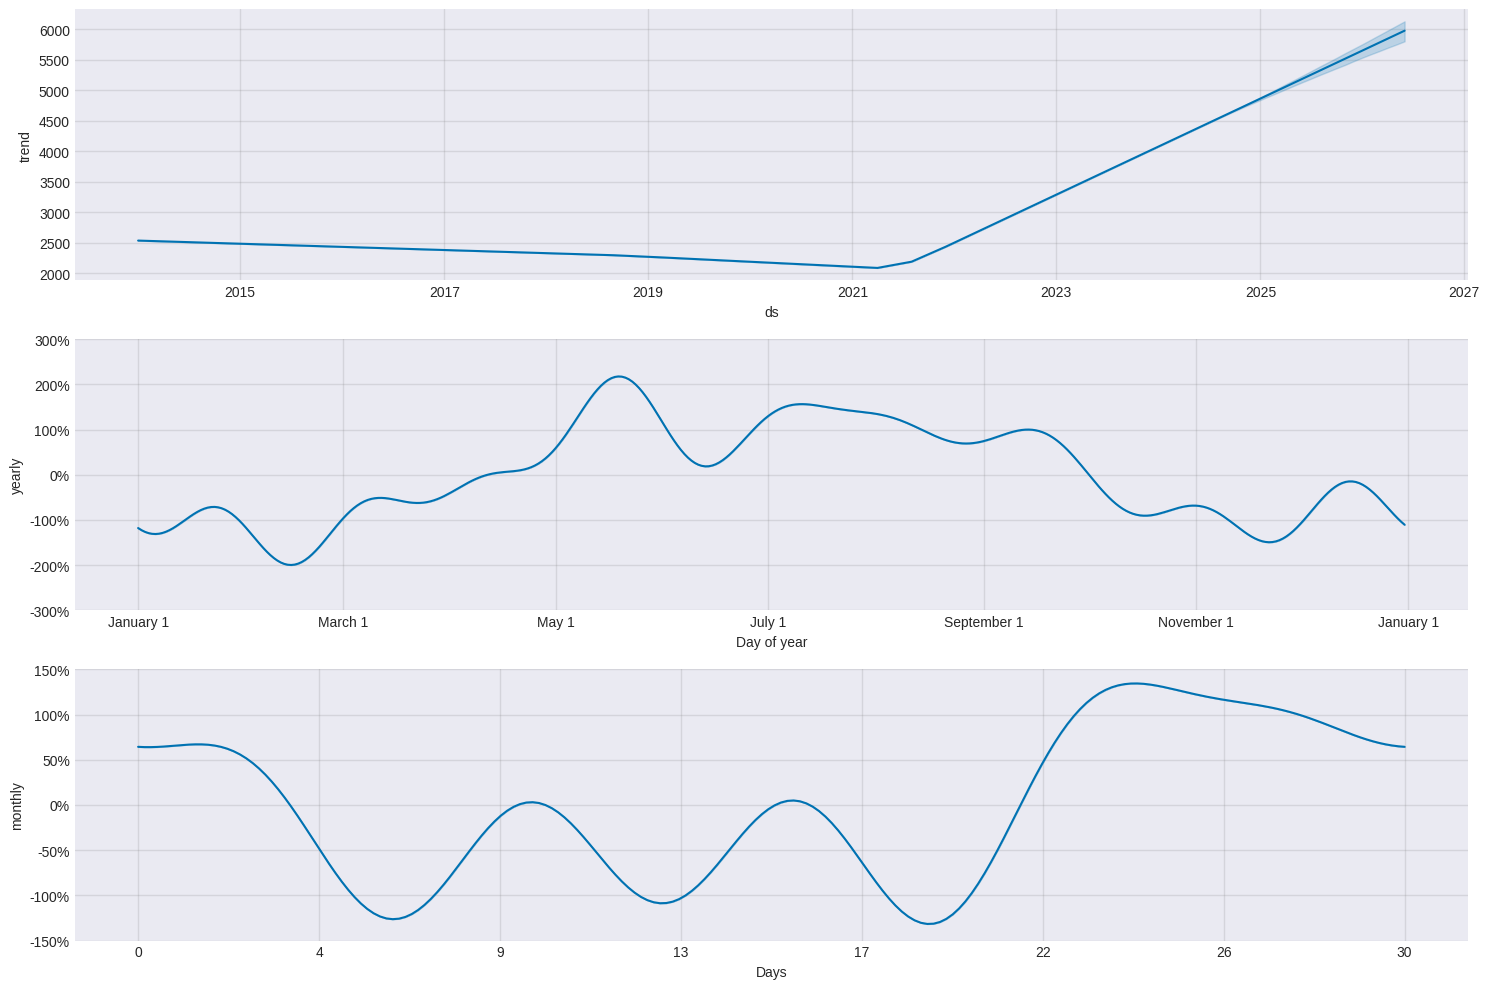

In [34]:
# Wizualizacja prognozy - Rowerzyści
fig3 = model_rowerzyści.plot(forecast_rowerzyści, figsize=(15, 6))
plt.title('Prognoza liczby świadczeń dla rowerzystów', fontsize=14, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Liczba świadczeń')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Komponenty modelu
fig4 = model_rowerzyści.plot_components(forecast_rowerzyści, figsize=(15, 10))
plt.tight_layout()
plt.show()

## 8. Porównanie prognoz

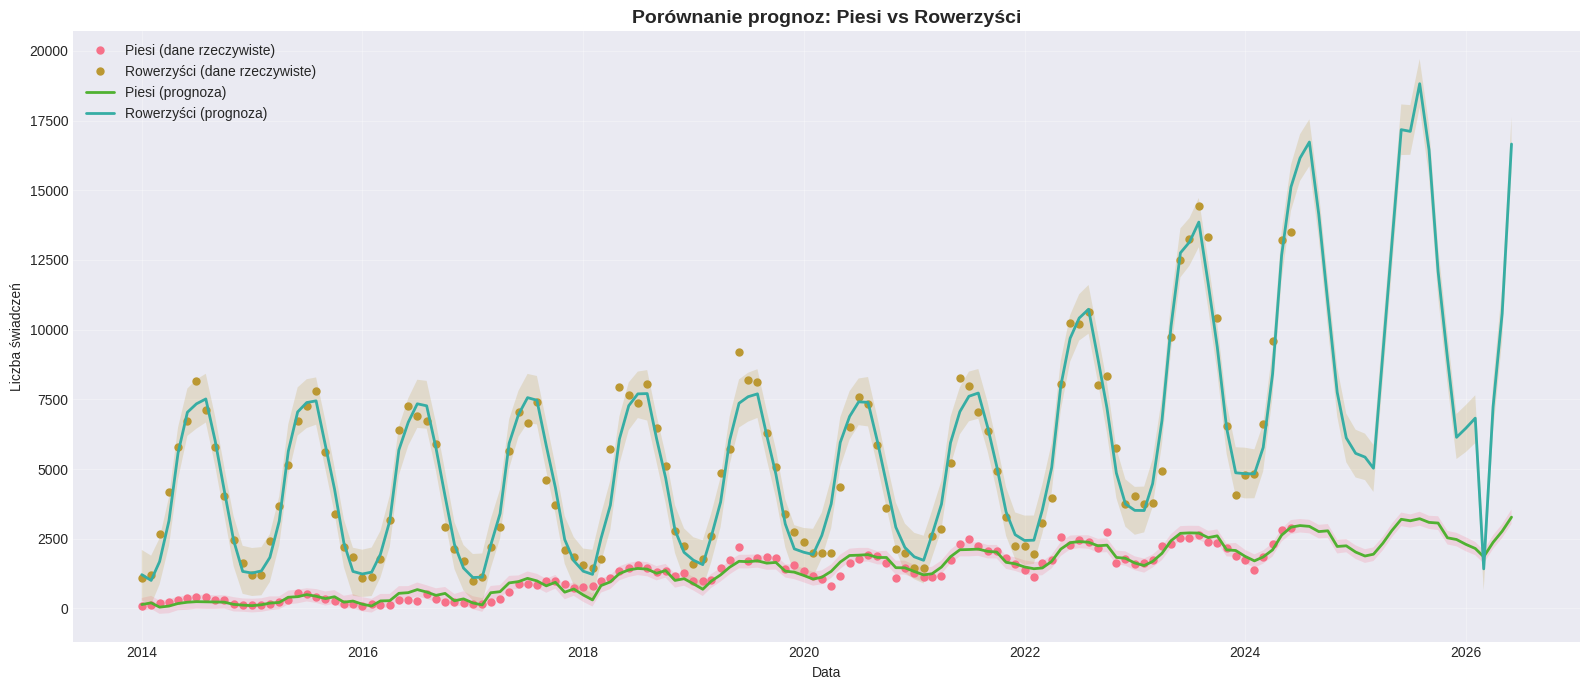

In [35]:
# Porównanie prognoz obu kategorii
plt.figure(figsize=(16, 7))

# Dane historyczne
plt.plot(df_prophet_piesi['ds'], df_prophet_piesi['y'], 'o', label='Piesi (dane rzeczywiste)', markersize=5)
plt.plot(df_prophet_rowerzyści['ds'], df_prophet_rowerzyści['y'], 'o', label='Rowerzyści (dane rzeczywiste)', markersize=5)

# Prognozy
plt.plot(forecast_piesi['ds'], forecast_piesi['yhat'], '-', label='Piesi (prognoza)', linewidth=2)
plt.plot(forecast_rowerzyści['ds'], forecast_rowerzyści['yhat'], '-', label='Rowerzyści (prognoza)', linewidth=2)

# Przedziały ufności
plt.fill_between(forecast_piesi['ds'], forecast_piesi['yhat_lower'], forecast_piesi['yhat_upper'], alpha=0.2)
plt.fill_between(forecast_rowerzyści['ds'], forecast_rowerzyści['yhat_lower'], forecast_rowerzyści['yhat_upper'], alpha=0.2)

plt.title('Porównanie prognoz: Piesi vs Rowerzyści', fontsize=14, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Liczba świadczeń')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Ewaluacja modelu

In [36]:
from prophet.diagnostics import cross_validation, performance_metrics

# Cross-validation dla modelu pieszych
print("=== CROSS-VALIDATION - PIESI ===")
df_cv_piesi = cross_validation(model_piesi, initial='730 days', period='180 days', horizon='365 days')
df_metrics_piesi = performance_metrics(df_cv_piesi)
print("\nMetryki modelu (Piesi):")
print(df_metrics_piesi[['horizon', 'mse', 'rmse', 'mae', 'mape', 'coverage']].head())

=== CROSS-VALIDATION - PIESI ===


  0%|          | 0/16 [00:00<?, ?it/s]23:57:02 - cmdstanpy - INFO - Chain [1] start processing
23:57:15 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:12<03:13, 12.91s/it]23:57:15 - cmdstanpy - INFO - Chain [1] start processing
23:57:30 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:28<03:23, 14.56s/it]23:57:30 - cmdstanpy - INFO - Chain [1] start processing
23:57:31 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:29<01:45,  8.09s/it]23:57:31 - cmdstanpy - INFO - Chain [1] start processing
23:57:31 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 4/16 [00:29<01:00,  5.07s/it]23:57:31 - cmdstanpy - INFO - Chain [1] start processing
23:57:31 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 5/16 [00:29<00:37,  3.38s/it]23:57:32 - cmdstanpy - INFO - Chain [1] start processing
23:57:32 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 6/16 [00:30<00:23,  2.37s/it]23:57:32


Metryki modelu (Piesi):
  horizon           mse        rmse         mae      mape  coverage
0 38 days  76632.089330  276.825016  222.704666  0.228639  0.368421
1 39 days  70126.390191  264.813878  204.526337  0.204404  0.421053
2 43 days  70278.120906  265.100209  205.233990  0.206258  0.368421
3 45 days  76047.006401  275.766217  219.376338  0.211896  0.315789
4 49 days  74651.015459  273.223380  215.015511  0.211280  0.315789


In [ ]:
# Cross-validation dla modelu rowerzystów
print("=== CROSS-VALIDATION - ROWERZYŚCI ===")
df_cv_row = cross_validation(model_rowerzyści, initial='730 days', period='180 days', horizon='365 days')
df_metrics_row = performance_metrics(df_cv_row)
print("\nMetryki modelu (Rowerzyści):")
print(df_metrics_row[['horizon', 'mse', 'rmse', 'mae', 'mape', 'coverage']].head())

In [ ]:
# Porównanie metryk
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# MAE
axes[0, 0].plot(df_metrics_piesi['horizon'], df_metrics_piesi['mae'], label='Piesi', marker='o')
axes[0, 0].plot(df_metrics_row['horizon'], df_metrics_row['mae'], label='Rowerzyści', marker='o')
axes[0, 0].set_title('Mean Absolute Error (MAE)')
axes[0, 0].set_xlabel('Horyzont prognozy')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# RMSE
axes[0, 1].plot(df_metrics_piesi['horizon'], df_metrics_piesi['rmse'], label='Piesi', marker='o')
axes[0, 1].plot(df_metrics_row['horizon'], df_metrics_row['rmse'], label='Rowerzyści', marker='o')
axes[0, 1].set_title('Root Mean Squared Error (RMSE)')
axes[0, 1].set_xlabel('Horyzont prognozy')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# MAPE
axes[1, 0].plot(df_metrics_piesi['horizon'], df_metrics_piesi['mape'], label='Piesi', marker='o')
axes[1, 0].plot(df_metrics_row['horizon'], df_metrics_row['mape'], label='Rowerzyści', marker='o')
axes[1, 0].set_title('Mean Absolute Percentage Error (MAPE)')
axes[1, 0].set_xlabel('Horyzont prognozy')
axes[1, 0].set_ylabel('MAPE')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Coverage
axes[1, 1].plot(df_metrics_piesi['horizon'], df_metrics_piesi['coverage'], label='Piesi', marker='o')
axes[1, 1].plot(df_metrics_row['horizon'], df_metrics_row['coverage'], label='Rowerzyści', marker='o')
axes[1, 1].set_title('Coverage (Pokrycie przedziałem ufności)')
axes[1, 1].set_xlabel('Horyzont prognozy')
axes[1, 1].set_ylabel('Coverage')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Podsumowanie i wnioski

In [ ]:
print("=== PODSUMOWANIE ANALIZY ===")
print("\n1. DANE:")
print(f"   - Okres analizy: {df_clean['Data'].min().date()} do {df_clean['Data'].max().date()}")
print(f"   - Liczba rekordów: {len(df_clean)}")
print(f"   - Kategorie: Piesi i Rowerzyści")

print("\n2. MODELE FACEBOOK PROPHET:")
print("   - Utworzono 2 osobne modele (dla pieszych i rowerzystów)")
print("   - Sezonowość: roczna + miesięczna")
print("   - Horyzont prognozy: 24 miesiące")

print("\n3. KLUCZOWE OBSERWACJE:")
print(f"   - Średnia liczba świadczeń (Piesi): {df_clean[df_clean['Kategoria']=='Piesi']['Liczba_świadczeń_num'].mean():.2f}")
print(f"   - Średnia liczba świadczeń (Rowerzyści): {df_clean[df_clean['Kategoria']=='Rowerzyści']['Liczba_świadczeń_num'].mean():.2f}")

# Analiza trendu
trend_piesi = forecast_piesi['trend'].iloc[-1] - forecast_piesi['trend'].iloc[0]
trend_row = forecast_rowerzyści['trend'].iloc[-1] - forecast_rowerzyści['trend'].iloc[0]

print(f"\n4. TRENDY:")
print(f"   - Trend dla pieszych: {'wzrostowy' if trend_piesi > 0 else 'spadkowy'} ({trend_piesi:.2f})")
print(f"   - Trend dla rowerzystów: {'wzrostowy' if trend_row > 0 else 'spadkowy'} ({trend_row:.2f})")

print("\n5. PROGNOZA NA NAJBLIŻSZE 12 MIESIĘCY:")
print("\nPiesi:")
next_12_piesi = forecast_piesi.tail(12)[['ds', 'yhat']].copy()
next_12_piesi['ds'] = next_12_piesi['ds'].dt.strftime('%Y-%m')
print(next_12_piesi.to_string(index=False))

print("\nRowerzyści:")
next_12_row = forecast_rowerzyści.tail(12)[['ds', 'yhat']].copy()
next_12_row['ds'] = next_12_row['ds'].dt.strftime('%Y-%m')
print(next_12_row.to_string(index=False))

## 11. Eksport wyników

In [ ]:
# Eksport prognoz do CSV
forecast_piesi[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('prognoza_piesi.csv', index=False)
forecast_rowerzyści[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('prognoza_rowerzyści.csv', index=False)

# Eksport przetworzonych danych
df_clean.to_csv('dane_przetworzone.csv', index=False)

# Eksport agregatów miesięcznych
df_monthly.to_csv('dane_miesieczne.csv', index=False)

print("Pliki zapisane:")
print("- prognoza_piesi.csv")
print("- prognoza_rowerzyści.csv")
print("- dane_przetworzone.csv")
print("- dane_miesieczne.csv")